In [138]:
import pandas as pd
import numpy as np
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.impute import SimpleImputer
pio.renderers.default = 'notebook'
sns.set_palette('bright')

pd.set_option('display.max_rows', 30)

sns.set_context(rc={"font.size":8,"axes.titlesize":10,"axes.labelsize":8}) 
%config InlineBackend.figure_format = 'retina'

загрузим очищенный датасет

In [139]:
df = pd.read_csv('clear_dataset.csv', index_col=0)
df.head()

,title,year,age,run,history,owners_pts,modification,volume,engine_type,transmission,...,wheel,exchange,mark,accident,other_history,tech_history,sold,pts_type,price,horse_power
0,Kia K900 3.3 AT,2019,II,91037,8.0,2,3.3 4WD AT,3.3,Бензин,Автомат,...,Левый,Возможен,соответствует,1,2,4,1,Другое,2999000,249
1,Mercedes-Benz V-класс 2.1 AT,2017,W447,95250,19.0,2,V 250 d 2.1 4MATIC AT L3,2.1,Дизель,Автомат,...,Левый,Не интересует,соответствует,0,2,19,2,Оригинал,5650000,190
2,Opel Astra GTC 1.4 AT,2013,J рестайлинг,113000,6.0,2,1.4 Turbo AT,1.4,Бензин,Автомат,...,Левый,Возможен,ниже,1,2,5,3,Другое,699000,140
3,Volkswagen Tiguan 2.0 AT,2015,I рестайлинг,165000,9.0,2,2.0 TDI 4Motion AT,2.0,Дизель,Автомат,...,Левый,Возможен,ниже,0,2,5,1,Другое,1195000,140
4,Ford Kuga 1.5 AT,2018,II рестайлинг,103000,16.0,1,1.5 EcoBoost 4WD AT,1.5,Бензин,Автомат,...,Левый,другое,соответствует,0,1,10,1,Оригинал,1780000,150


In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1698 entries, 0 to 1697
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          1698 non-null   object 
 1   year           1698 non-null   int64  
 2   age            1698 non-null   object 
 3   run            1698 non-null   int64  
 4   history        1698 non-null   float64
 5   owners_pts     1698 non-null   object 
 6   modification   1698 non-null   object 
 7   volume         1698 non-null   float64
 8   engine_type    1698 non-null   object 
 9   transmission   1698 non-null   object 
 10  gear           1698 non-null   object 
 11  body           1698 non-null   object 
 12  color          1698 non-null   object 
 13  wheel          1698 non-null   object 
 14  exchange       1698 non-null   object 
 15  mark           1698 non-null   object 
 16  accident       1698 non-null   int64  
 17  other_history  1698 non-null   int64  
 18  tech_history 

Большинство переменных в нашем датасете являются категориальными, однако есть несколько числовых переменных. Рассмотрим распределение числовых и категориальных признаков, чтобы лучше понимать соотношение категорий и значений

In [141]:

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.to_list()
cat_cols = df.select_dtypes(include=['object']).columns.to_list()


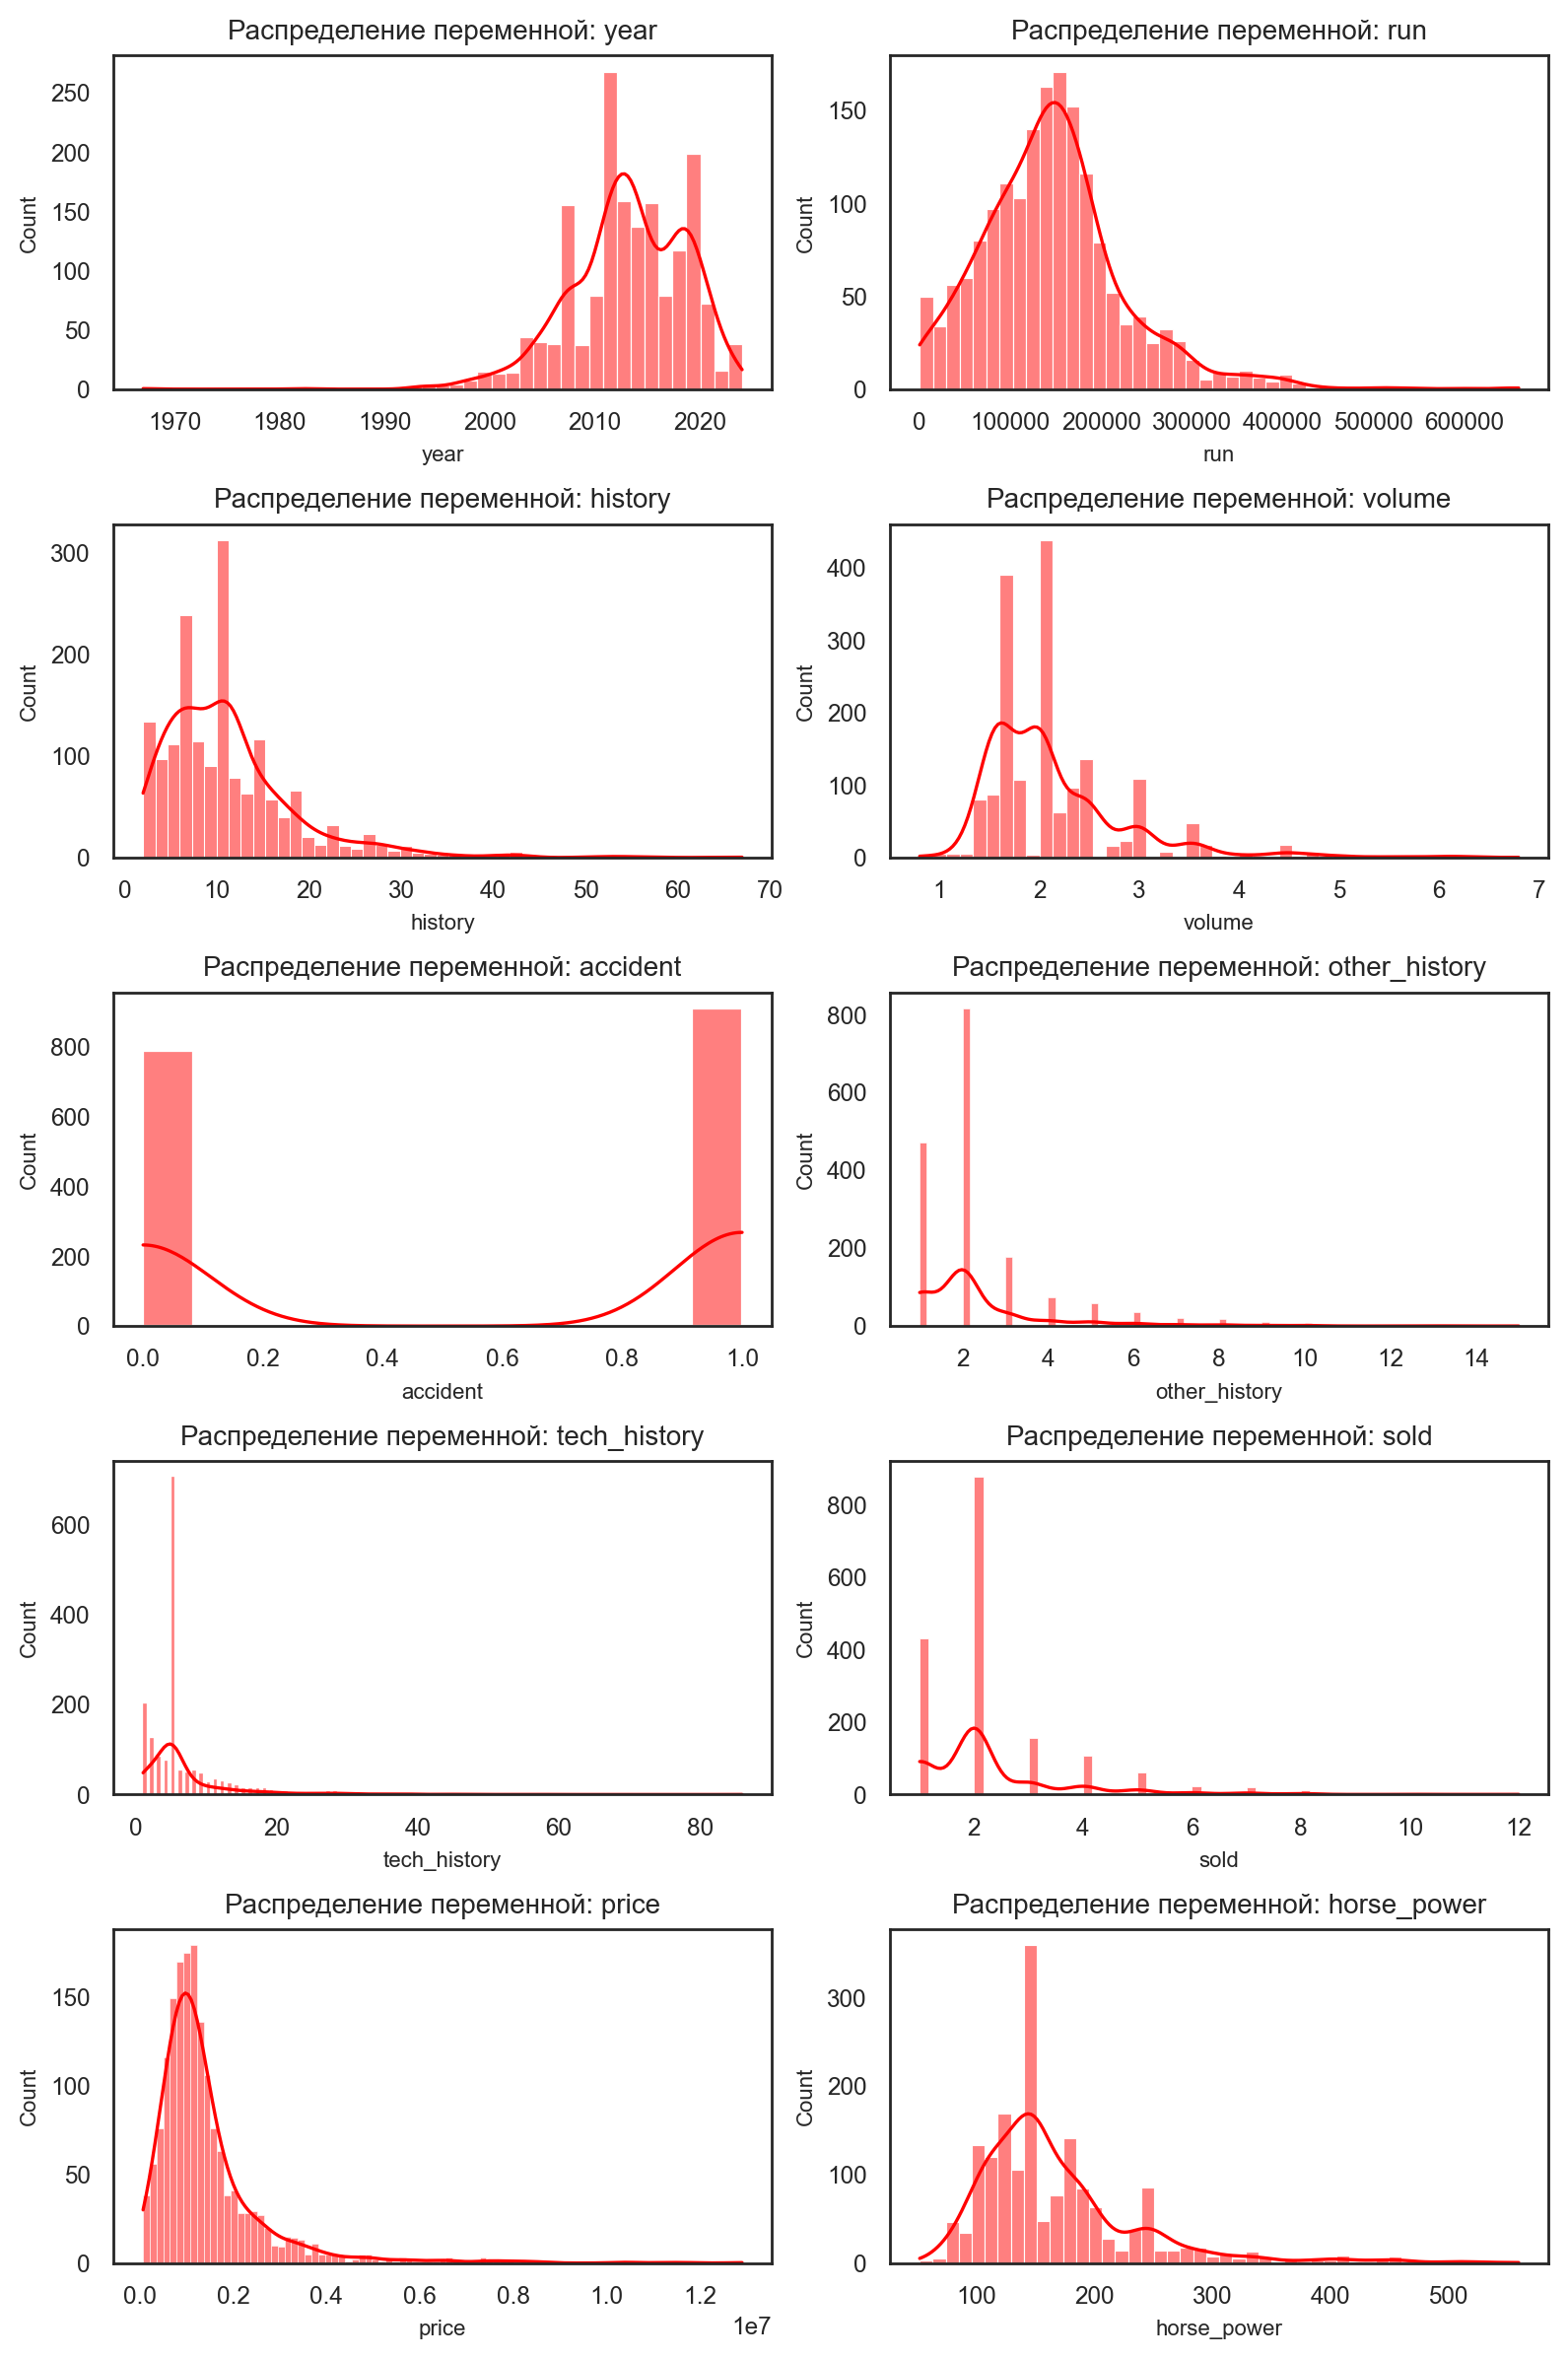

In [142]:
fig, axes = plt.subplots(5, 2, figsize=(8, 12))
axes = axes.flatten()

# Loop through each numeric column and plot a histogram
for i, col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes[i], kde=True, color='red') 
    axes[i].set_title(f'Распределение переменной: {col}') 
    axes[i].tick_params(axis='both')
    

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

а также посмотрим на статистики данных признаков:

In [143]:
df.describe()

,year,run,history,volume,accident,other_history,tech_history,sold,price,horse_power
count,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1.698000e+03,1698.000000
mean,2013.157833,147104.740872,11.267397,2.141281,0.535925,2.356890,6.915194,2.275029,1.450681e+06,168.058304
std,5.579326,80746.798570,7.497241,0.737547,0.498855,1.703012,7.298896,1.414330,1.240806e+06,69.097922
min,1967.000000,1.000000,2.000000,0.800000,0.000000,1.000000,1.000000,1.000000,7.300000e+04,52.000000
25%,2010.000000,96000.000000,6.000000,1.600000,0.000000,1.000000,4.000000,1.000000,7.850000e+05,123.000000
50%,2013.000000,142383.500000,10.000000,2.000000,1.000000,2.000000,5.000000,2.000000,1.125500e+06,150.000000
75%,2018.000000,183768.250000,14.000000,2.400000,1.000000,2.000000,7.000000,2.000000,1.650000e+06,190.000000
max,2024.000000,660000.000000,67.000000,6.800000,1.000000,15.000000,86.000000,12.000000,1.290000e+07,560.000000


- Видим, что в переменная года выпуска распределена достаточно неравномерно и присутствуют выбросы до 2000х годов, но основные значения распределены от 2010 до 2018.
- Пробег распределен более равномерно, хоть и присутствует перекос влево, как и у переменных истории пробега, количества лошадиных сил и цены. 
- Объем двигателя распределен менее равномерно и с перекосом влево, и большинство значений распределено около 2х
- Число записей о техобслуживании (что можно отнести в категориальный признак) имеет большое число выбросов и выделяющуюся категорию около 10 => требуется отдельно рассмотреть релевантность использования данной переменной

*Категориальные признаки*
- Налиие или отсутвие информации о ДТП (accident) распределена приблизительно равномерно
- other_history – история владельцев - имеет несколько мелких категорий на числе владельцев больше 6
- Число продаж имеет самое частое значение – 2, однако значения меньше 6 также встречаются часто. В целом число продаж на авито и число предыдущех владельцев распределены примрено одинаково (есть отличие около 5-6 владельцев/продаж), из чего можем сделать предположение о том что практически всегда машины, продающиеся на авито несколько раз имеют нескольких владельцев-пользователей Авито


Сделаем то же самое для категориальных признаков, но не будем брать в расчет название (title), age (поколение) и modification – модификация автомобиля, так как в данных признаках слишком много значений и мы рассмотрим их отдельно

In [144]:
cat_cols_display = [i for i in cat_cols if i not in ['title', 'age', 'modification']]

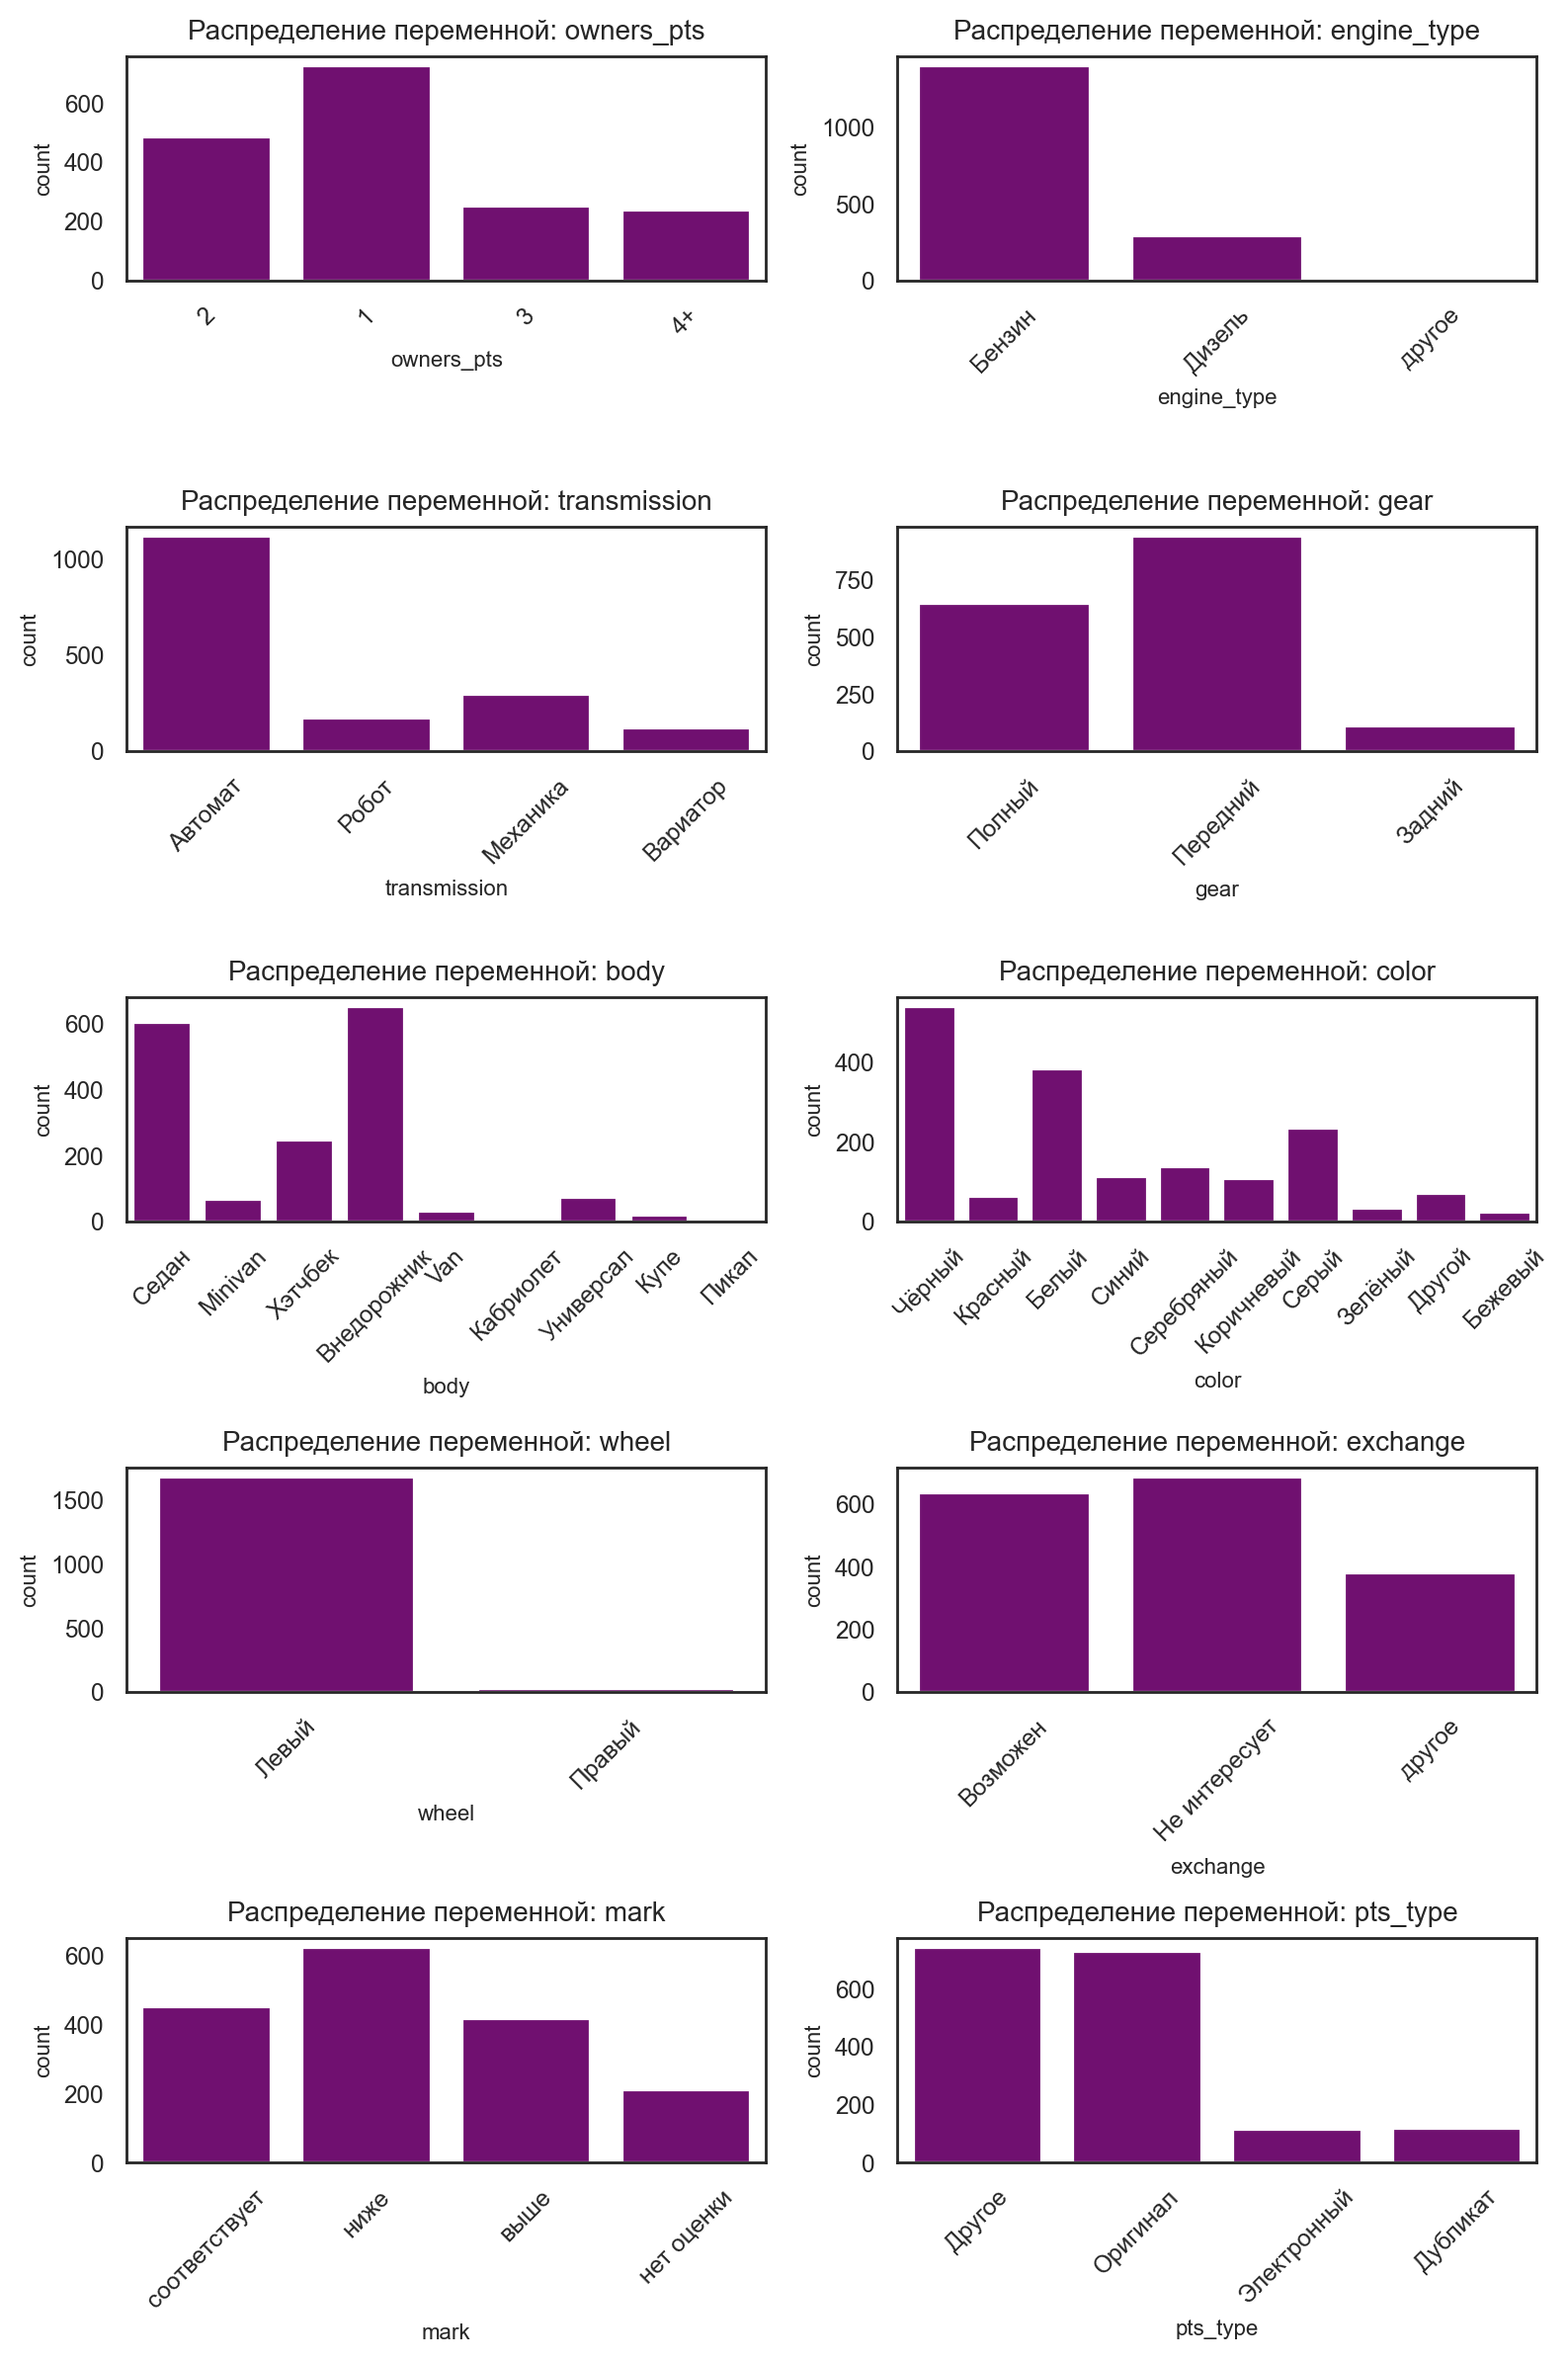

In [145]:
fig, axes = plt.subplots(5, 2, figsize=(8, 12))
axes = axes.flatten()

# Loop through each numeric column and plot a histogram
for i, col in enumerate(cat_cols_display):
    sns.countplot(data=df, x=col, ax=axes[i], color='purple') 
    axes[i].set_title(f'Распределение переменной: {col}') 
    axes[i].tick_params(axis='x', labelrotation=45)
    

plt.tight_layout()
plt.show()

In [146]:
df.describe(include='object')


,title,age,owners_pts,modification,engine_type,transmission,gear,body,color,wheel,exchange,mark,pts_type
count,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698,1698
unique,638,227,4,401,3,4,3,9,10,2,3,4,4
top,Kia Sportage 2.0 AT,I,1,1.6 AT,Бензин,Автомат,Передний,Внедорожник,Чёрный,Левый,Не интересует,ниже,Другое
freq,47,301,723,153,1394,1115,940,650,536,1676,684,622,740


В категориальныых признаках есть признаки отвечающий за тип руля, который разделен очень неравномерно, и engine_type, очень маленьким числом значений, попадающим в категорию другое. Переведем тип руля в бинарный признак, а тип бензина из категории другое переведем в бинарный признак

In [147]:
df['wheel'] = df['wheel'].map({'Правый': 0, 'Левый': 1}).astype(int)
df['engine_type'] = df['engine_type'].map({'другое':0, 'Бензин': 0, 'Дизель': 1}).astype(int)

Для окончания общего анализа перемнных, построим матрецу корреляций между переменными и ценой. Однако сначала посмотрим сгладится ли распределение цены при применении функции логарифма к ней.

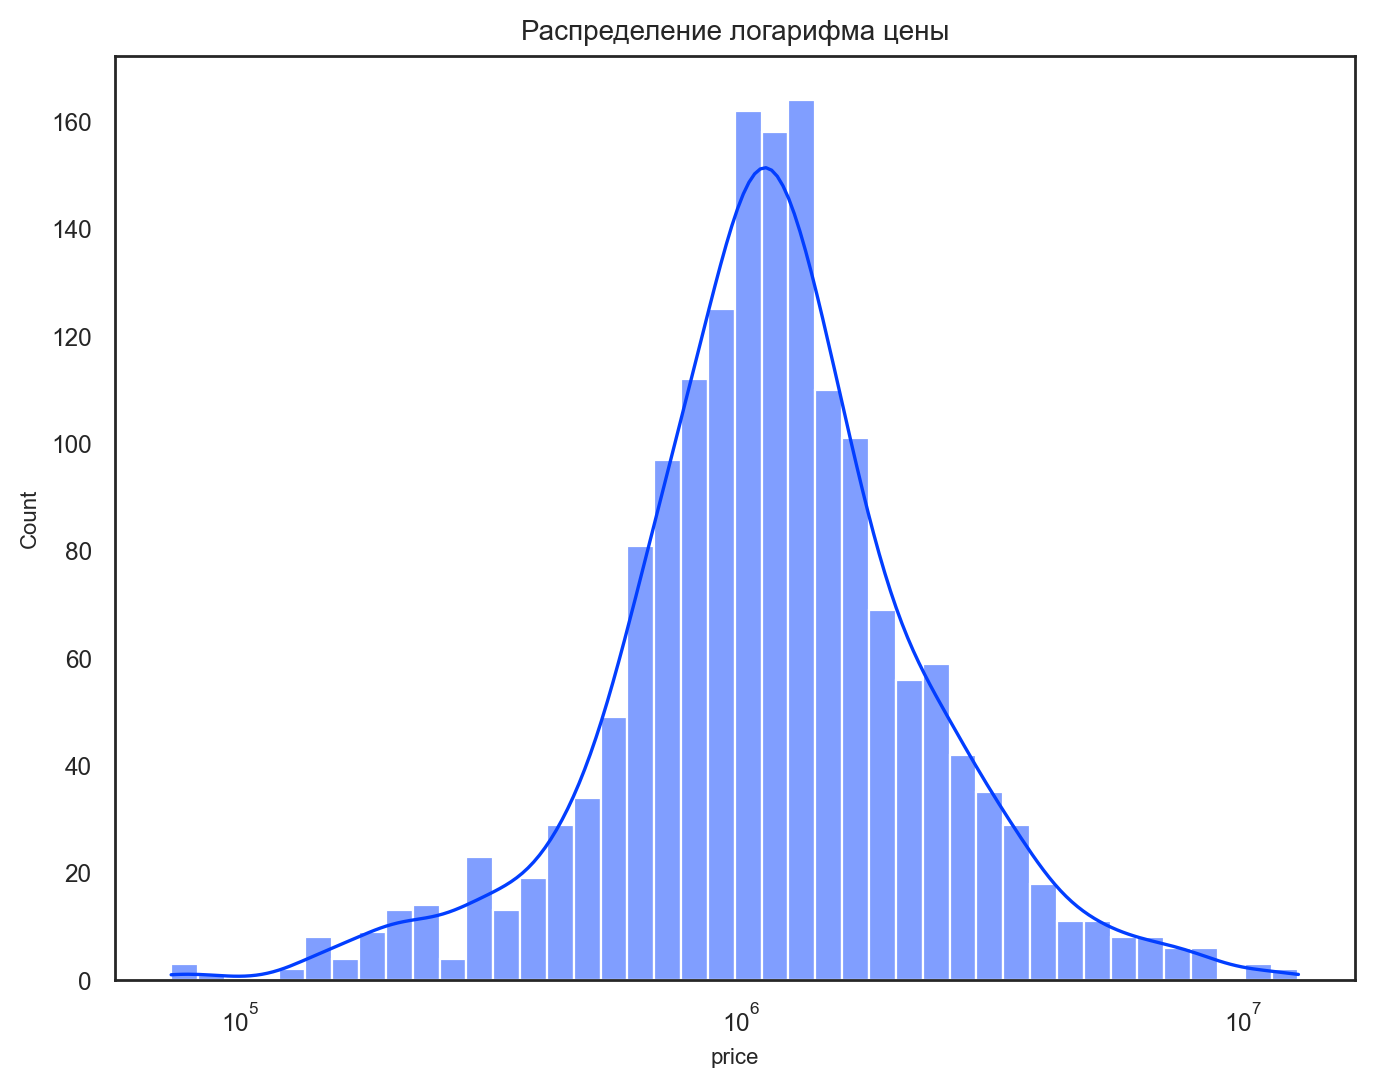

In [148]:
plt.figure(figsize=(8, 6))
sns.histplot(df['price'], kde=True, log_scale=True) 
plt.title(f'Распределение логарифма цены') 
plt.show()

Видим, что значение сгладилось, а значит его использование вдальнейшем будет лучше для анализа

In [149]:
df['price_log'] = np.log(df['price'] + 1)
num_cols = df.select_dtypes([int, float]).columns.to_list()

In [150]:
num_cols

['year',
 'run',
 'history',
 'volume',
 'engine_type',
 'wheel',
 'accident',
 'other_history',
 'tech_history',
 'sold',
 'price',
 'horse_power',
 'price_log']

Для окончания общего анализа и перехода к более конкретным переменным и зависимости между ними, построем корреляционную матрицу

<Axes: >

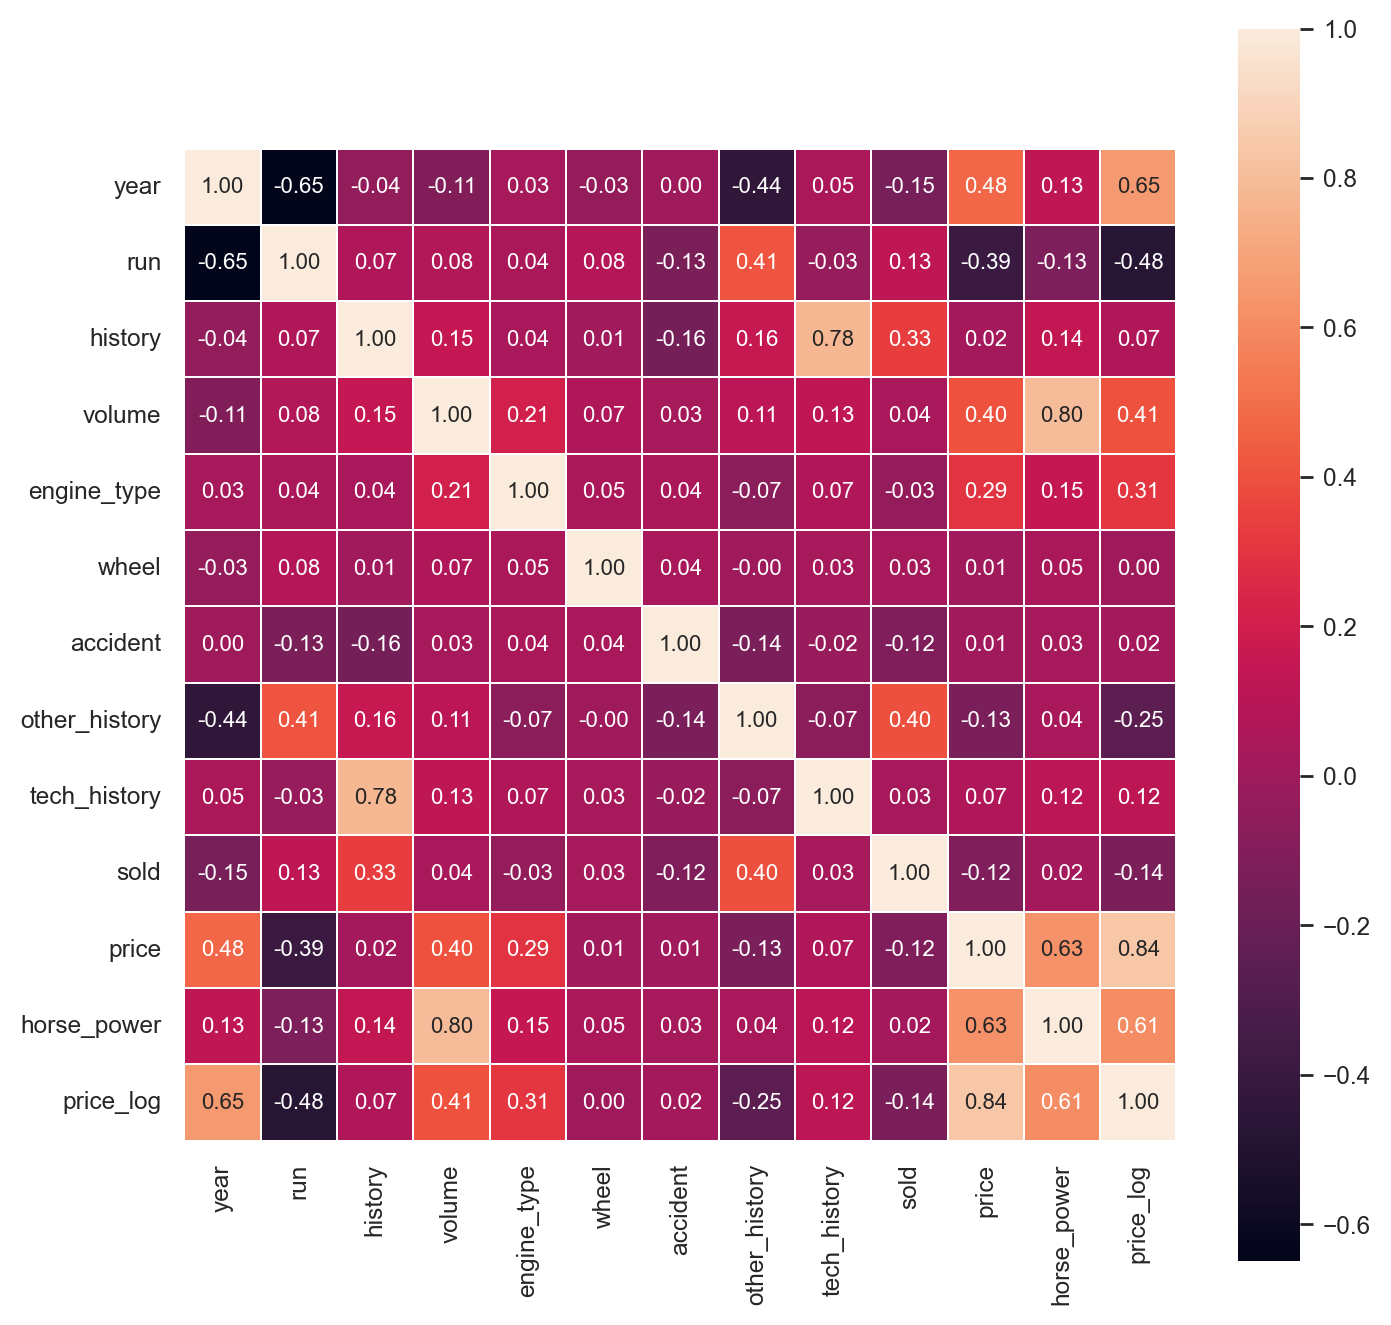

In [151]:
plt.figure(figsize=(8, 8))
corr = df[num_cols].corr()
sns.heatmap(corr, square=True, annot=True, fmt='.2f', linewidths=0.15)

Из анализа матрицы корреляций видим, что тип руля (значение которого практически всегда принимает значение левый), наличие информации о ДТП и об истории пробега имеют практически нулевую корреляцию с целевой переменной, поэтому их можно выкинуть из дальнейшего анализа

In [152]:
df.drop(columns=['wheel', 'history', 'accident'], inplace=True)

Важным замечанием является то, что wheel и accident в целом слабо коррелируют со всеми другими переменными, однако есть значительная взаимосвязь с истории пробега с историей техобслуживания и количеством продаж машины на авито.

Сделаем основные выводы по коррелирующим с ценой переменной:
- Больше всего на цену влияет год выпуска и личество лошадиных сил (напрямую зависящий от объема двигателя).
- Обратное влияние на цену имеет пробег (то есть чем пробег ниже тем выше цена, что в целом достаточно логично)
- Число предыдущих владельцев (other history) немного отрицательно влияет на цену, как и число предыдущих продаж. 
- Что интересно, информация о техобслуживании не сильно, но положительно коррелирут с ценой, как и объем и тип двигателя


Так как число лошадиных сил, год выпуска и пробег являются исходно числовыми переменными, то можем визуализировать их взаимосвязь с ценой в ScatterPlot

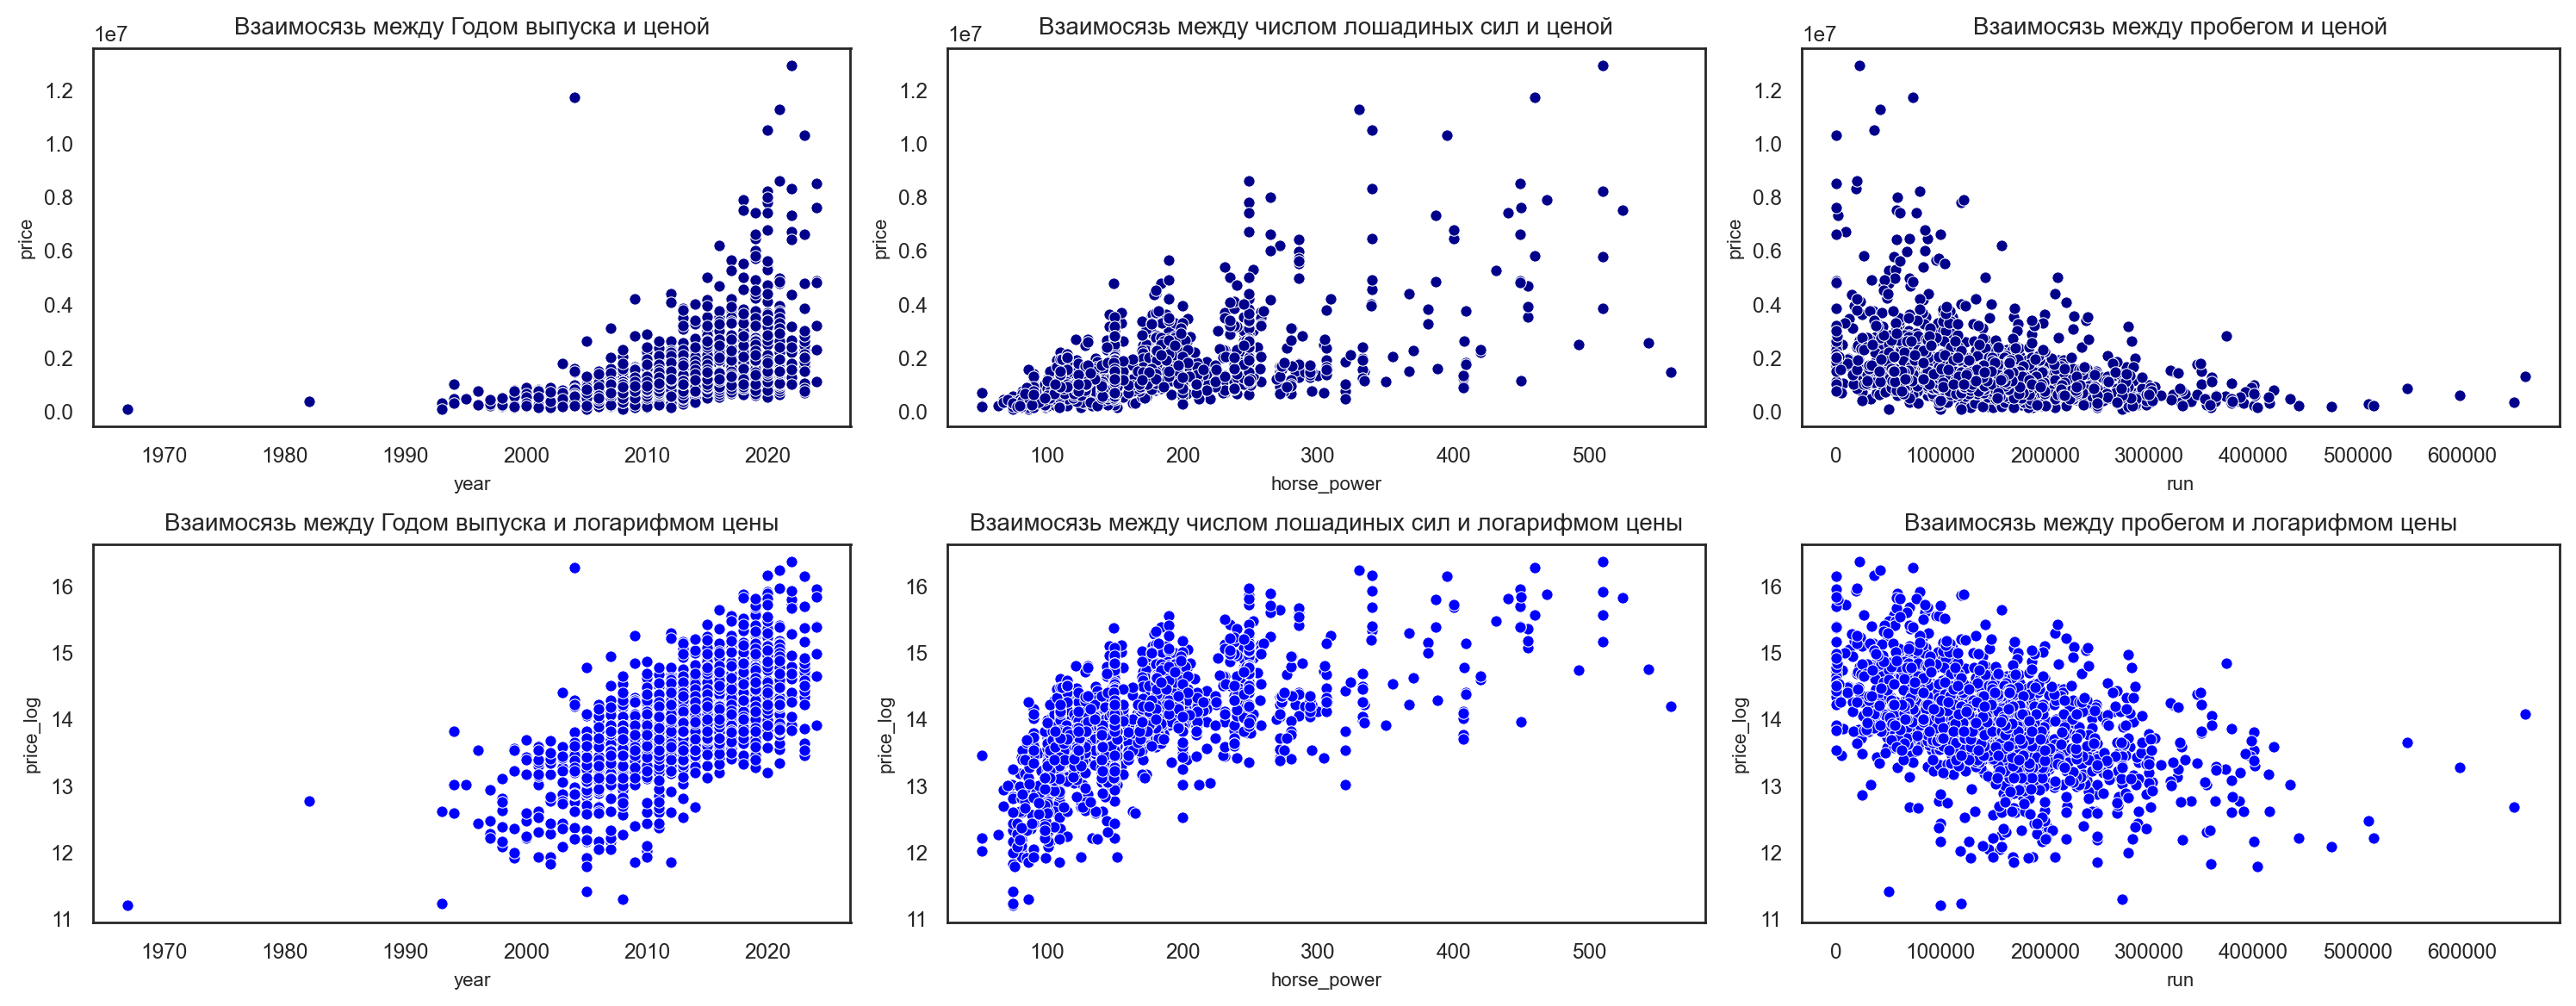

In [153]:
cols_analyse = ['year', 'horse_power', 'run']
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
translate_cols = {'year': 'Годом выпуска', 'horse_power': 'числом лошадиных сил', 'run':'пробегом'}

for i, col in enumerate(cols_analyse):
    sns.scatterplot(data=df, x=col, y='price', ax=axes[i], color='darkblue') 
    axes[i].set_title(f'Взаимосязь между {translate_cols[col]} и ценой')

for i, col in enumerate(cols_analyse):
    sns.scatterplot(data=df, x=col, y='price_log', ax=axes[i+3], color='blue') 
    axes[i + 3].set_title(f'Взаимосязь между {translate_cols[col]} и логарифмом цены')


plt.tight_layout()
plt.show()


Забавно почти зеркальное поведение пробега и года выпуска. При этом более классический прямой пид зависимости принимает число лошадиных сил. Более привыяные (и прямые) зависимости заметны при использовании логарифма в качетсве переменной с которой ищется взаимосвязь


Также интересно посмотреть на распределение связи числа предыдущих продаж и числа предыдущих владельцев, однако для исследования их взаимосвязи построим ящики с усами из-за того, что данные переменные ближе к категориальным. 

Из-за того, что на гистограммах выше мы видим практически отсутствие значений больше 6 для данных признаков, то можем не рассматривать их в построении ящиков с усами

<Figure size 1500x600 with 0 Axes>

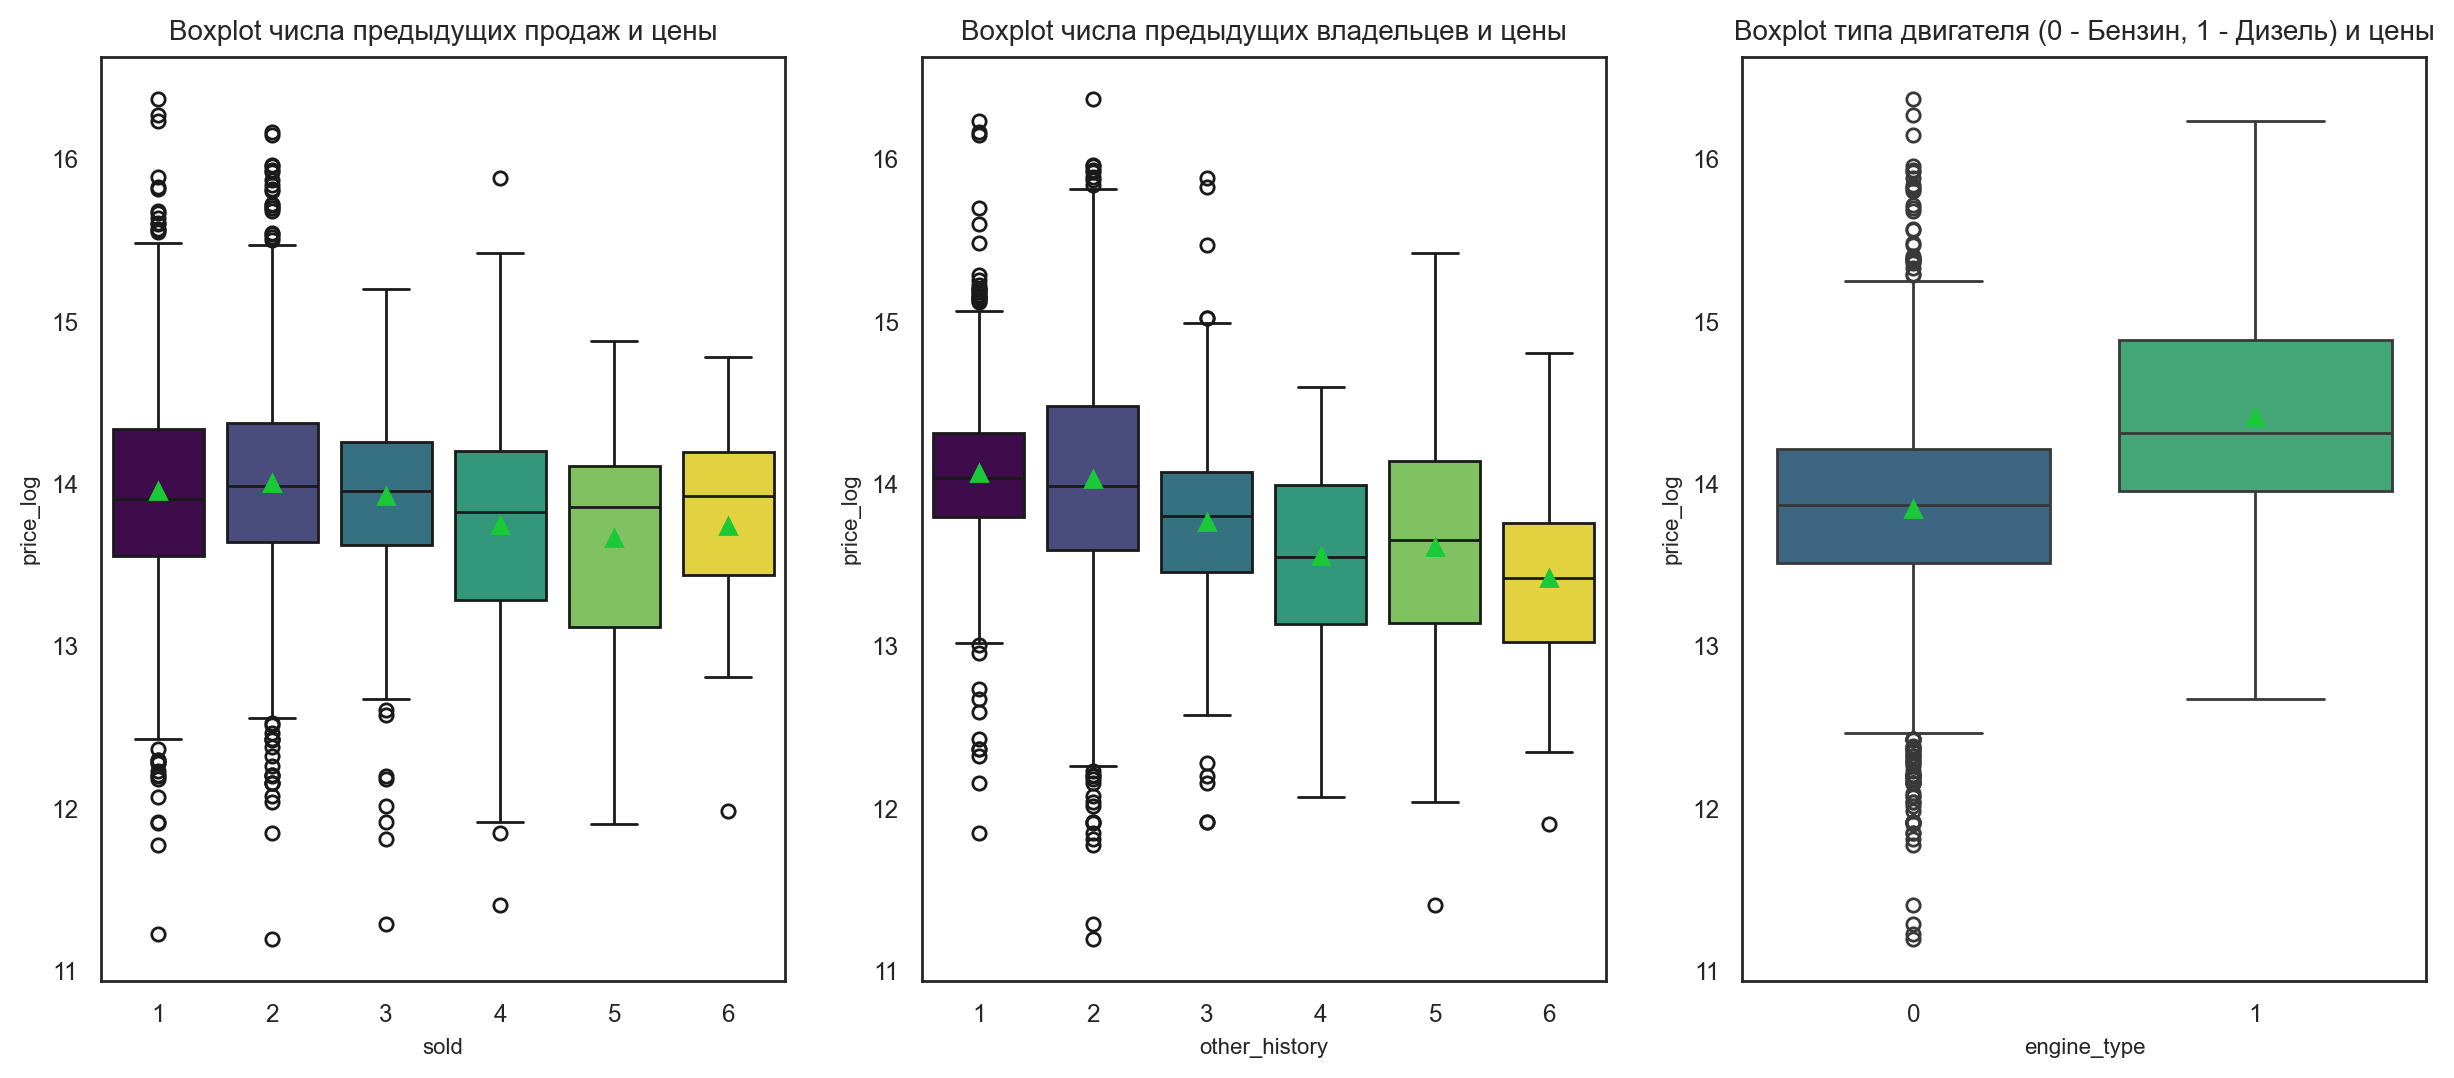

In [157]:
plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
axes = axes.flatten()

sns.boxplot(x='sold', y='price_log', data=df[df['sold'] <= 6], showmeans=True, hue='sold', legend=False, ax=axes[0], palette='viridis')
axes[0].set_title('Boxplot числа предыдущих продаж и цены')

sns.boxplot(x='other_history', y='price_log', data=df[df['other_history'] <= 6], showmeans=True, hue='other_history', legend=False, ax=axes[1], palette='viridis')
axes[1].set_title('Boxplot числа предыдущих владельцев и цены')

sns.boxplot(x='engine_type', y='price_log', data=df, showmeans=True, hue='engine_type', legend=False, ax=axes[2], palette='viridis')
axes[2].set_title('Boxplot типа двигателя (0 - Бензин, 1 - Дизель) и цены')
plt.show()

Видим, что данные признаки распределены очень похожим образом, однако средние значения для числа предыдущих продаж ближе к 14, а значения для истории владельцев распределена сильнее. Также заметна очень небольшая отрицательная корреляция логарифма цены и рассматриваемых признаков, при этом цена сильнее уменьшается при росте числа владельцев, чем при увеличении числа предыдущих продаж на Авито.

**Промежуточные выводы исследования числовых и некоторыз категориальных признаков**

1. год выпуска и число лошадиных сил сильно положительно влияют на цену, то есть чем новее и мощнее автомобиль, его цена выше
2. Пробег, число предыдущих владельцев и продаж  отрицательно влияют на цену, т. е. чем "изношеннее" автомобиль его цена ниже

При этом цены распределены в определенном промежутке (до 4х миллионов)

Приступим к анализу связи цены и категориальных признаков